In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
from sklearn import preprocessing

In [2]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
SIGNALS = ["body_acc_x_", "body_acc_y_", "body_acc_z_",
           "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
           "total_acc_x_", "total_acc_y_", "total_acc_z_"]

train_paths = ['./UCI HAR Dataset/train/Inertial Signals/' + signal + 'train.txt' for signal in SIGNALS]
test_paths = ['./UCI HAR Dataset/test/Inertial Signals/' + signal + 'test.txt' for signal in SIGNALS]

In [3]:
def load_X(X_signal_paths):
    X_signals = []

    for signal_type_path in X_signal_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

In [4]:
x_train = load_X(train_paths)
x_test = load_X(test_paths)

In [5]:
y_train = np.loadtxt('./UCI HAR Dataset/train/y_train.txt',  dtype=np.int32)
y_test = np.loadtxt('./UCI HAR Dataset/test/y_test.txt', dtype=np.int32)

y_train = np.asarray([[y] for y in y_train])
y_test = np.asarray([[y] for y in y_test])

In [6]:
print('x_train shape is: ', x_train.shape)
print('x_test shape is: ', x_test.shape)

print('y_train shape is: ', y_train.shape)
print('y_test shape is: ', y_test.shape)


x_train shape is:  (7352, 128, 9)
x_test shape is:  (2947, 128, 9)
y_train shape is:  (7352, 1)
y_test shape is:  (2947, 1)


In [7]:
print(np.unique(y_train))

[1 2 3 4 5 6]


In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)

categories = enc.categories_[0]
print(categories)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print("Shape of y_train_onehot")
print(y_train_onehot.shape)
print("Shape of y_test_onehot")
print(y_test_onehot.shape)

[1 2 3 4 5 6]
Shape of y_train_onehot
(7352, 6)
Shape of y_test_onehot
(2947, 6)


In [18]:
from keras.layers import Embedding, Dense, LSTM
from keras.losses import BinaryFocalCrossentropy
from keras.models import Sequential
from keras import  optimizers

model = Sequential()
model.add(LSTM(175, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(6, activation='softmax'))

additional_metrics = ['accuracy']
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=additional_metrics)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 175)               129500    
                                                                 
 dense_3 (Dense)             (None, 6)                 1056      
                                                                 
Total params: 130,556
Trainable params: 130,556
Non-trainable params: 0
_________________________________________________________________


In [19]:
print((type(x_test)))
print((type(y_test_onehot)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [20]:
history = model.fit(x_train, y_train_onehot, batch_size=128, epochs=20,
                    validation_split=0.15, verbose=1)

test_result = model.evaluate(x_test, y_test_onehot)

print(f'Test result - Loss: {test_result[0]} - Accuracy: {100*test_result[1]}%')

Epoch 1/20
49/49 [==============================] - 14s 249ms/step - loss: 1.2475 - accuracy: 0.4780 - val_loss: 1.2095 - val_accuracy: 0.5249
Epoch 2/20
49/49 [==============================] - 13s 271ms/step - loss: 0.8872 - accuracy: 0.6302 - val_loss: 1.0898 - val_accuracy: 0.5684
Epoch 3/20
49/49 [==============================] - 15s 314ms/step - loss: 0.7667 - accuracy: 0.6846 - val_loss: 0.9924 - val_accuracy: 0.6591
Epoch 4/20
49/49 [==============================] - 16s 334ms/step - loss: 0.6159 - accuracy: 0.7651 - val_loss: 0.8197 - val_accuracy: 0.7289
Epoch 5/20
49/49 [==============================] - 16s 334ms/step - loss: 0.4989 - accuracy: 0.8041 - val_loss: 0.8812 - val_accuracy: 0.7035
Epoch 6/20
49/49 [==============================] - 17s 340ms/step - loss: 0.4231 - accuracy: 0.8505 - val_loss: 0.7631 - val_accuracy: 0.8087
Epoch 7/20
49/49 [==============================] - 15s 313ms/step - loss: 0.3405 - accuracy: 0.8851 - val_loss: 0.6183 - val_accuracy: 0.8132

In [23]:
import matplotlib.pyplot as plt

def plot(train_hist):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(train_hist.history['accuracy'])
    axs[0].plot(train_hist.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'])

    axs[1].plot(train_hist.history['loss'])
    axs[1].plot(train_hist.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'])

    plt.tight_layout()
    plt.show()

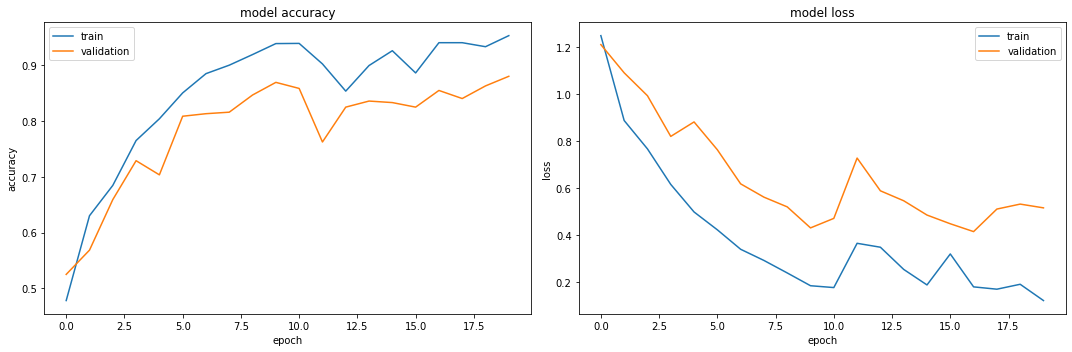

In [24]:
plot(history)

In [30]:
from tensorflow.python.keras.layers.recurrent import PeepholeLSTMCell
from tensorflow.python.keras.layers import RNN


model = Sequential()
peephole_cell = PeepholeLSTMCell(175)

PeepholeLayer = RNN(peephole_cell, input_shape=(128, 9))

model.add(PeepholeLayer)
model.add(Dense(6, activation='softmax'))

additional_metrics = ['accuracy']
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=additional_metrics)

model.build()

C:\Users\billz\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2579: UserWarning: `tf.keras.experimental.PeepholeLSTMCell` is deprecated and will be removed in a future version. Please use tensorflow_addons.rnn.PeepholeLSTMCell instead.
  warnings.warn('`tf.keras.experimental.PeepholeLSTMCell` is deprecated '


ValueError: You must provide an `input_shape` argument.

In [29]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.